# **Automated Signal Processing Pipeline for IoT Sensor Data: Applications in Motion and Environmental Sensors**
**By Victoria Ofuasia**


# **Description:**  
This project presents a versatile Python-based signal processing pipeline tailored for analyzing and filtering data from IoT sensors, including motion sensors. The pipeline is flexible and supports various numeric time-series data, such as temperature, motion, pressure, or other sensor outputs, making it ideal for a wide range of IoT applications.

### **Key Features:**  
- **Data Loading**: Reads data from CSV files and extracts the relevant column for processing, with support for customizable data formats.  
- **Preprocessing**: Normalizes the input signal to a range between -1 and 1, ensuring uniformity and preparing it for further analysis.  
- **Filtering**: Implements a low-pass Butterworth filter to remove noise and highlight key signal components, such as sustained motion or trends in sensor readings.  
- **Frequency Analysis**: Performs Fast Fourier Transform (FFT) to reveal frequency-domain characteristics of the filtered signal.  
- **Visualization**: Produces clear plots of the original signal, filtered signal, and frequency spectrum for comprehensive analysis.

### **Libraries/Tools Used:**  
- **NumPy**: Facilitates numerical operations and signal processing.  
- **Pandas**: Efficiently loads and processes CSV data.  
- **SciPy**: Provides tools like the Butterworth filter for signal processing tasks.  
- **Matplotlib**: Generates intuitive visualizations of signals and frequency spectra.

### **Adaptability and Automation:**  
- Capable of handling any numeric time-series data, including motion sensor data like acceleration or velocity readings.  
- Automates the signal processing steps, minimizing manual effort and errors.  
- Modular design allows for easy customization and integration into larger IoT systems.

### **Applications:**  
- **Motion Analysis**: Detect and analyze movement patterns or vibrations in systems equipped with motion sensors.  
- **Environmental Monitoring**: Process data from temperature, pressure, or humidity sensors for trend analysis.  
- **Healthcare Analytics**: Analyze wearable device data to monitor motion or physiological parameters.  
- **Industrial IoT**: Evaluate sensor data in automated systems to detect anomalies or optimize performance.  

This pipeline is a robust solution for processing motion sensor data or any IoT-based numeric data, providing critical insights through automation and visualization.

# Setup  

This setup configures the Python environment with essential libraries for signal processing and analysis. The environment is based on the `kaggle/python` Docker image, which comes with a wide range of analytics tools pre-installed. 


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

%matplotlib inline
import numpy as np # preprocess, analyse signal
import pandas as pd # load signal
import matplotlib.pyplot as plt # for visualization
from scipy.signal import butter, lfilter # apply filter to signal


# Kaggle Dataset Access  

In this setup, the input data files are stored in the read-only `../input/` directory. You can access these files to load your datasets. The following code can be used to list all the files (datasets) in the input directory:

```python
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
```
**Note: If you are not running this project on Kaggle, ignore this.**

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Input  
This section defines the input for processing either **motion sensor data** or **environmental sensor data**. You can customize the dataset path and column name at any time to suit your needs.

- **Dataset Path**: Specify the path to your sensor data file.  
- **Column to Process**: Define the specific column you want to analyze from the dataset (e.g., 'attitude.pitch' for motion sensor or 'humidity' for environmental sensor).


In [3]:
#Example 1: Motion sensor dataset
dataset_type = 'Motion Sensor Data'
dataset_path = '//kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/jog_9/sub_10.csv'
column_to_process = 'gravity.x'

In [4]:
# # Example 2: Environmental sensor dataset
# dataset_type = 'Environmental Sensor Data'
# dataset_path = '/kaggle/input/environmental-sensor-data-132k/iot_telemetry_data.csv'
# column_to_process = 'smoke'

# Automated Steps

## Step 1: Load Signal Data

This function `load_signal` is designed to load signal data from a CSV file. It takes two parameters:
- `file_path`: the path to the CSV file containing the dataset.
- `signal_column`: the name of the column in the CSV file that holds the signal data to be processed.

Using the `pandas` library, the function reads the CSV file, extracts the values from the specified column, and returns them as a NumPy array, which is used for further signal processing tasks.


In [5]:
# Step 1: Load Signal Data
def load_signal(file_path, signal_column):
    # Load the CSV file using pandas
    data = pd.read_csv(file_path)
    signal = data[signal_column].values

    return signal

## Step 2: Preprocess Signal

This function processes the signal to prepare it for further analysis:

1. **Remove DC Component**:  
   The mean of the signal is subtracted from each data point, removing the **DC component** (the average value), leaving only the **AC (alternating)** components.

2. **Normalization**:  
   The signal is normalized between -1 and 1. This is done by scaling the signal so that its minimum value maps to -1 and its maximum value maps to 1, ensuring consistency across signals and improving the performance of analysis.

This preprocessing step centers and scales the signal for more accurate analysis and processing.


In [6]:
# Step 2: Preprocess Signal
def preprocess_signal(signal):    
    # Subtract the mean to remove the DC component
    signal = signal - np.mean(signal)
    
    # Normalize the signal between -1 and 1
    signal_min, signal_max = np.min(signal), np.max(signal)
    normalized_signal = 2 * (signal - signal_min) / (signal_max - signal_min) - 1
    return normalized_signal

## Step 3: Apply Filters

The function `butter_lowpass` designs a **low-pass Butterworth filter**:

1. **Parameters**:
   - `cutoff`: The cutoff frequency, above which frequencies are attenuated.
   - `fs`: The sampling frequency of the signal.
   - `order`: The order of the filter, affecting the steepness of the cutoff.

2. **Calculation**:
   - The Nyquist frequency is calculated as half of the sampling frequency.
   - The cutoff frequency is normalized by dividing it by the Nyquist frequency.
   - The `butter` function from `scipy.signal` is used to generate the filter coefficients (`b`, `a`).
     - **Analog=False** specifies that the filter is a **digital filter**, meaning it will be applied to discrete-time signals (sampled data). If set to `True`, it would design an **analog filter** for continuous-time signals.


The `apply_filter()` function applies the low-pass filter to the given signal.

- It first calls the `butter_lowpass()` function to get the filter coefficients (`b` and `a`).
- The `lfilter()` function then applies the filter to the signal using the calculated coefficients. This step is where the signal is actually filtered based on the cutoff frequency and filter order.

The result is a **filtered signal** that has had higher frequency noise (above the cutoff) attenuated/removed, leaving only the desired low-frequency components.

In [7]:
# Step 3: Apply Filters
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [8]:
def apply_filter(signal, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order)
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

## Step 4: Analyze Signal (FFT)

The `analyze_signal()` function performs a Fast Fourier Transform (FFT) on the given signal to analyze its frequency content.

- `np.fft.rfftfreq(n, 1/fs)` computes the frequencies corresponding to the FFT results, where `n` is the number of samples and `fs` is the sampling frequency.
- `np.fft.rfft(signal)` computes the one-dimensional n-point FFT for real input, which is more efficient for real-valued signals.
- The magnitude of the FFT is computed using `np.abs()` to convert the complex numbers to their magnitudes.

The function returns:
- `f`: The array of frequency values (in Hz).
- `fft_magnitude`: The corresponding magnitudes of the frequency components, representing the signal's power at different frequencies.


In [9]:
# Step 4: Analyze Signal (FFT)
def analyze_signal(signal, fs):
    n = len(signal)
    f = np.fft.rfftfreq(n, 1/fs)
    fft_magnitude = np.abs(np.fft.rfft(signal))
    return f, fft_magnitude

### Step 5: Visualize and Save Results

In this step, the original signal, the processed (filtered) signal, and the frequency spectrum (FFT magnitude) are visualized in three subplots. The results help to understand the signal's behavior in both the time and frequency domains. Here's a brief explanation:

1. **Original Signal Plot**:
   - This subplot shows the signal as it was loaded from the data source, before any preprocessing or filtering.
   - It helps in understanding the raw signal and any noise or patterns it may contain.

2. **Filtered Signal Plot**:
   - This subplot shows the signal after it has been processed (e.g., after filtering).
   - By comparing this plot with the original signal, you can visually assess how the filter has affected the signal, such as removing noise or smoothing out the signal.

3. **Frequency Spectrum (FFT Magnitude)**:
   - This subplot displays the frequency content of the signal.
   - It shows how the energy is distributed across different frequencies. Peaks in the plot represent dominant frequency components.

The `plt.tight_layout()` ensures that the subplots are neatly spaced. Optionally, the plot can be saved using `plt.savefig()` if desired.


This visualization gives a complete view of the signal's transformation from raw data to the processed version and its frequency content.

In [10]:
# Step 5: Visualize and Save Results
def visualize_signal(original_signal, processed_signal, fft_freq, fft_magnitude, data_title):
    plt.figure(figsize=(12, 8))
    
    # Set the overall title for the entire figure
    plt.suptitle(data_title, fontsize=16)
    
    # Original Signal
    plt.subplot(3, 1, 1)
    plt.plot(original_signal)
    plt.title("Original Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")

    # Filtered Signal
    plt.subplot(3, 1, 2)
    plt.plot(processed_signal, color='orange')
    plt.title("Filtered Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")

    # FFT Magnitude
    plt.subplot(3, 1, 3)
    plt.plot(fft_freq, fft_magnitude, color='green')
    plt.title("Frequency Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")

    # Add a vertical line at the cutoff frequency indicating the point (5oHz) where the filter started reducing the other frequencies above it
    plt.axvline(x=cutoff_freq, color='red', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')


    # Apply logarithmic scale if needed to y-axis for better visualization
    plt.yscale('log')

    # Set frequency limit if necessary (example: show only up to 80 Hz)
    plt.xlim(0, 80)  # Adjust the limit based on your data

    plt.tight_layout()
    plt.show()

# Main Pipeline Execution

This section executes the entire automated signal processing pipeline. The script performs the automated steps:

1. **Load Signal Data**: 
   The signal data is loaded from the specified dataset path and column using the `load_signal()` function. The `dataset_path` and `column_to_process` specify the data source and the specific sensor reading (e.g., humidity or motion sensor data).

2. **Preprocess the Signal**: 
   The signal is preprocessed by removing the DC component (mean) and normalizing the signal to a range between -1 and 1 using the `preprocess_signal()` function.

3. **Apply a Low-Pass Filter**: 
   A low-pass filter is applied to the preprocessed signal using the `apply_filter()` function. The cutoff frequency is set to 50 Hz, and the sampling rate is 1000 Hz. This step is intended to remove high-frequency noise from the signal.

4. **Analyze the Signal using FFT**: 
   The filtered signal is analyzed using the Fast Fourier Transform (FFT) to obtain the frequency spectrum. This is done using the `analyze_signal()` function, which returns the frequency bins and the corresponding magnitudes.

5. **Visualize Results**: 
   The original signal, filtered signal, and frequency spectrum are visualized using the `visualize_signal()` function. The plots help to compare the raw signal with the processed signal and observe the frequency content of the signal.

The script serves as an end-to-end solution for loading, preprocessing, filtering, analyzing, and visualizing time-series sensor data, such as environmental or motion sensor data.

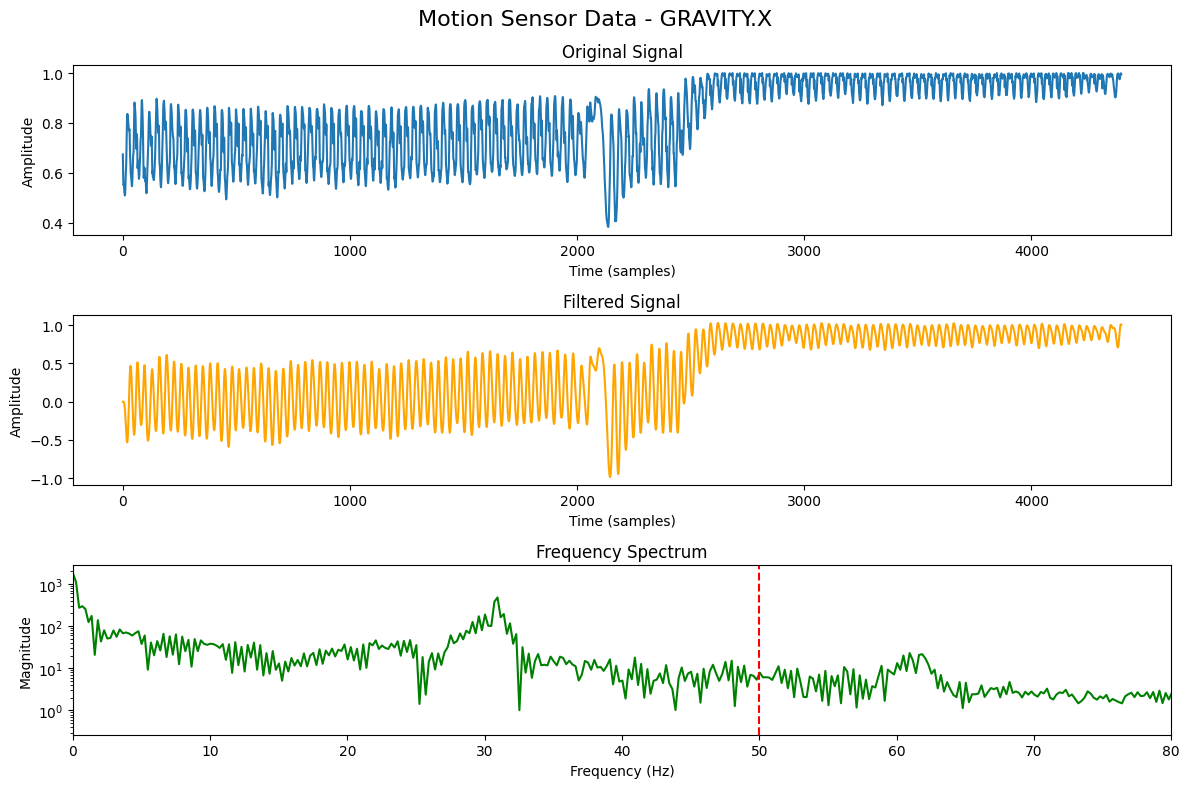

In [11]:
# Main Pipeline Execution
if __name__ == "__main__":
    # Load signal data
    signal = load_signal(dataset_path, column_to_process)

    # Preprocess the signal
    normalized_signal = preprocess_signal(signal)

    # Apply a low-pass filter
    cutoff_freq = 50  # Hz
    sampling_rate = 1000  # Hz
    filtered_signal = apply_filter(normalized_signal, cutoff_freq, sampling_rate)

    # Analyze the signal using FFT
    fft_freq, fft_magnitude = analyze_signal(filtered_signal, sampling_rate)

    # Visualize results
    data_title = f"{dataset_type} - {column_to_process.upper()}"
    visualize_signal(signal, filtered_signal, fft_freq, fft_magnitude, data_title)
